In [1]:
# ===== LOAD LIBRARIES & DATA =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix

# Load preprocessed data once
df = pd.read_csv('weatherAUS_preprocessed.csv')
print(f"Loaded dataset: {df.shape}")


Loaded dataset: (86424, 65)


In [2]:
# ===== HELPERS: PREPARE DATA + TRAIN/EVAL PIPELINE =====
def prepare_target(df, target):
    """Return X, y for given binary target. Drops the target column from features."""
    if target not in df.columns:
        raise KeyError(f"Target '{target}' not found in dataframe")
    X = df.drop(columns=[target])
    y = df[target].astype(int)
    return X, y

def train_and_eval(X, y, target_name, random_state=42, test_size=0.2):
    """Train models and return a dict of metrics and trained estimators."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    models = {
        'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=random_state),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=10, class_weight='balanced', random_state=random_state, n_jobs=-1),
        'DecisionTree': DecisionTreeClassifier(max_depth=10, min_samples_split=20, class_weight='balanced', random_state=random_state),
        'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True, random_state=random_state),
        'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # some models support predict_proba; fallback to decision_function when needed
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except Exception:
            # fallback (e.g., if model doesn't implement predict_proba)
            try:
                y_scores = model.decision_function(X_test)
                # scale to 0-1 for roc_auc
                y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)
            except Exception:
                y_proba = np.zeros(len(y_test))

        acc = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else np.nan
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        precision = (cm[1][1] / (cm[1][1] + cm[0][1])) if (cm[1][1] + cm[0][1]) > 0 else 0
        recall = (cm[1][1] / (cm[1][1] + cm[1][0])) if (cm[1][1] + cm[1][0]) > 0 else 0

        results[name] = {
            'model': model,
            'accuracy': acc,
            'roc_auc': roc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'confusion_matrix': cm
        }

    # Add feature importance for RF and coefficients for LR (if applicable)
    try:
        results['RandomForest']['feature_importance'] = pd.DataFrame({
            'Feature': X.columns,
            'Importance': results['RandomForest']['model'].feature_importances_
        }).sort_values('Importance', ascending=False)
    except Exception:
        pass

    try:
        results['LogisticRegression']['coefficients'] = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': results['LogisticRegression']['model'].coef_[0]
        }).assign(Abs_Coefficient=lambda df_: df_['Coefficient'].abs()).sort_values('Abs_Coefficient', ascending=False)
    except Exception:
        pass

    meta = {'n_train': len(X_train), 'n_test': len(X_test), 'target': target_name}
    return results, meta


In [ ]:
# ===== RUN PIPELINE FOR BOTH TARGETS =====
targets = ['RainTomorrow', 'RainToday']
all_results = {}

for tgt in targets:
    print('\n' + '='*60)
    print(f"Processing target: {tgt}")
    print('='*60)
    X, y = prepare_target(df, tgt)
    print(f"Features: {X.shape}, Target distribution: \n{y.value_counts().to_dict()}")
    results, meta = train_and_eval(X, y, tgt)
    # Summarize compactly
    summary_rows = []
    for name, info in results.items():
        summary_rows.append({
            'Model': name,
            'Accuracy': info['accuracy'],
            'ROC-AUC': info['roc_auc'],
            'F1': info['f1'],
            'Precision': info['precision'],
            'Recall': info['recall']
        })
    summary_df = pd.DataFrame(summary_rows).sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
    print('\nModel summary:')
    print(summary_df.to_string(index=False))
    all_results[tgt] = {'results': results, 'meta': meta, 'summary': summary_df}

print('\nDone. All targets processed.')



Processing target: RainTomorrow
Features: (19998, 64), Target distribution: 
{0: 12565, 1: 7433}

Model summary:
             Model  Accuracy  ROC-AUC       F1  Precision   Recall
      RandomForest   0.82500 0.899958 0.767750   0.757695 0.778077
               SVM   0.80875 0.889047 0.763816   0.706050 0.831876
LogisticRegression   0.78100 0.872254 0.731123   0.672501 0.800941
      DecisionTree   0.78275 0.845136 0.721742   0.688875 0.757902
               KNN   0.78150 0.842800 0.689189   0.731321 0.651648

Processing target: RainToday
Features: (19998, 64), Target distribution: 
{0: 12462, 1: 7536}

Model summary:
             Model  Accuracy  ROC-AUC       F1  Precision   Recall
      RandomForest   0.82500 0.899958 0.767750   0.757695 0.778077
               SVM   0.80875 0.889047 0.763816   0.706050 0.831876
LogisticRegression   0.78100 0.872254 0.731123   0.672501 0.800941
      DecisionTree   0.78275 0.845136 0.721742   0.688875 0.757902
               KNN   0.78150 0.842800 

In [112]:
# ===== FEATURE IMPORTANCE & TOP FEATURES (per target) =====
for tgt, payload in all_results.items():
    print('\n' + '='*60)
    print(f"Top features for target: {tgt}")
    print('='*60)
    res = payload['results']
    if 'RandomForest' in res and 'feature_importance' in res['RandomForest']:
        print('\nRandomForest top 10:')
        print(res['RandomForest']['feature_importance'].head(10).to_string(index=False))
    if 'LogisticRegression' in res and 'coefficients' in res['LogisticRegression']:
        print('\nLogisticRegression top 10:')
        print(res['LogisticRegression']['coefficients'].head(10).to_string(index=False))

    # Print best model by weighted score
    df_summary = payload['summary']
    df_summary['Weighted'] = (df_summary['Accuracy']*0.25 + df_summary['ROC-AUC']*0.35 + df_summary['F1']*0.25 + df_summary['Recall']*0.15)
    best_row = df_summary.loc[df_summary['Weighted'].idxmax()]
    print(f"\nBest model (weighted) for {tgt}: {best_row['Model']} (score={best_row['Weighted']:.4f})")



Top features for target: RainTomorrow

RandomForest top 10:
      Feature  Importance
  Humidity3pm    0.152298
     Sunshine    0.135567
     Cloud3pm    0.091548
  Pressure3pm    0.058075
  Evaporation    0.055007
     Cloud9am    0.051665
WindGustSpeed    0.049552
  Pressure9am    0.046202
  Humidity9am    0.042224
      Temp3pm    0.033440

LogisticRegression top 10:
       Feature  Coefficient  Abs_Coefficient
   Pressure3pm    -1.207408         1.207408
   Humidity3pm     1.201035         1.201035
   Pressure9am     0.830815         0.830815
 WindGustSpeed     0.827043         0.827043
      Sunshine    -0.448701         0.448701
     RainToday    -0.434407         0.434407
 WindGustDir_W     0.399387         0.399387
      Cloud3pm     0.398105         0.398105
WindDir9am_NNE     0.374252         0.374252
WindDir3pm_NNW     0.348966         0.348966

Best model (weighted) for RainTomorrow: RandomForest (score=0.8299)

Top features for target: RainToday

RandomForest top 10:
   

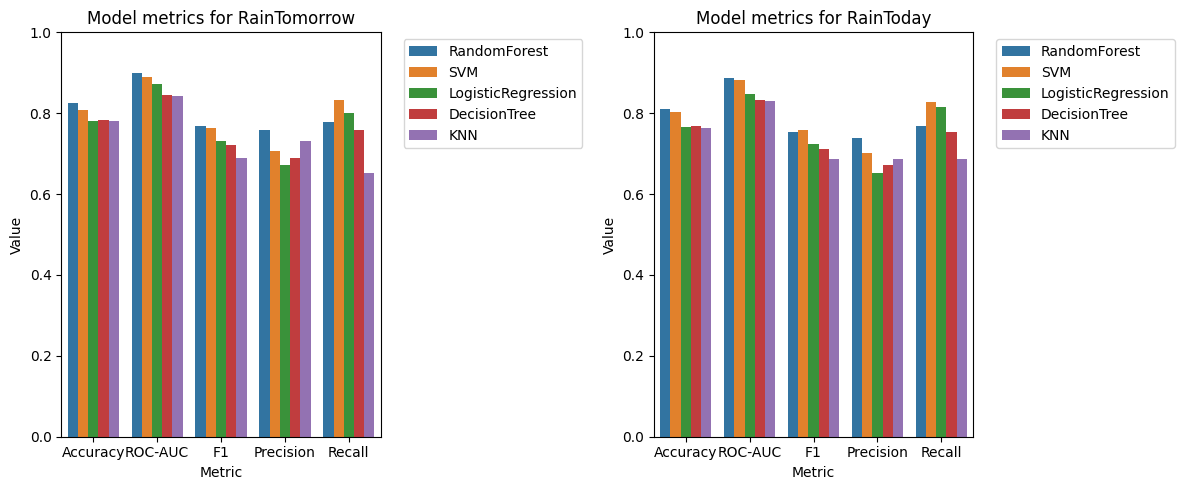

In [113]:
# ===== COMPARISON PLOT (per-target models) =====
fig, axes = plt.subplots(1, len(all_results), figsize=(6 * len(all_results), 5))
if len(all_results) == 1:
    axes = [axes]

for ax, (tgt, payload) in zip(axes, all_results.items()):
    df_plot = payload['summary'].melt(id_vars=['Model'], value_vars=['Accuracy','ROC-AUC','F1','Precision','Recall'], var_name='Metric', value_name='Value')
    sns.barplot(data=df_plot, x='Metric', y='Value', hue='Model', ax=ax)
    ax.set_title(f"Model metrics for {tgt}")
    ax.set_ylim(0,1)
    ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')

plt.tight_layout()
plt.show()


In [114]:
# ===== QUICK DIAGNOSTICS =====
for tgt, payload in all_results.items():
    print('\n' + '-'*40)
    print(f"Diagnostics for {tgt}: n_train={payload['meta']['n_train']}, n_test={payload['meta']['n_test']}")
    print(payload['summary'][['Model','Accuracy','ROC-AUC','F1']].to_string(index=False))

# Check for missing values once
print('\nOverall missing values in dataset:', df.isnull().sum().sum())



----------------------------------------
Diagnostics for RainTomorrow: n_train=15998, n_test=4000
             Model  Accuracy  ROC-AUC       F1
      RandomForest   0.82500 0.899958 0.767750
               SVM   0.80875 0.889047 0.763816
LogisticRegression   0.78100 0.872254 0.731123
      DecisionTree   0.78275 0.845136 0.721742
               KNN   0.78150 0.842800 0.689189

----------------------------------------
Diagnostics for RainToday: n_train=15998, n_test=4000
             Model  Accuracy  ROC-AUC       F1
      RandomForest   0.81025 0.887419 0.753331
               SVM   0.80200 0.881104 0.759271
LogisticRegression   0.76600 0.847085 0.724219
      DecisionTree   0.76875 0.832027 0.710485
               KNN   0.76450 0.829796 0.687251

Overall missing values in dataset: 0
